In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
import re
from pathlib import Path
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import json


cwd = os.getcwd()

# Add directories for modules and data files
dirs = [x[0] for x in os.walk(cwd)]
[sys.path.append(d) for d in dirs]
data_dir = cwd+'\\Input\\DataFiles\\' # Manual way; TODO: find a relative way to do this automatically
vegas_dir = cwd+'\\Input\\VegasOdds\\'

import elo


In [2]:
p = Path('.')
paths = list(p.glob('**/*.csv'))
paths

[WindowsPath('odds_2017_basic.csv'),
 WindowsPath('Input/DataFiles/Cities.csv'),
 WindowsPath('Input/DataFiles/ConferenceTourneyGames.csv'),
 WindowsPath('Input/DataFiles/EloHistory.csv'),
 WindowsPath('Input/DataFiles/GameCities.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneyDetailedResults.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySeeds.csv'),
 WindowsPath('Input/DataFiles/NCAATourneySlots.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonCompactResults.csv'),
 WindowsPath('Input/DataFiles/RegularSeasonDetailedResults.csv'),
 WindowsPath('Input/DataFiles/SeasonElos.csv'),
 WindowsPath('Input/DataFiles/SeasonElosK25.csv'),
 WindowsPath('Input/DataFiles/Seasons.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyCompactResults.csv'),
 WindowsPath('Input/DataFiles/SecondaryTourneyTeams.csv'),
 WindowsPath('Input/DataFiles/TeamCoaches.csv'),
 WindowsPath('Input/DataFiles/Teams.csv'),
 WindowsPath('Input/DataFiles/Team

In [3]:
teams = pd.read_csv(data_dir+'Teams.csv')
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [4]:
team_spellings = pd.read_csv(data_dir+'TeamSpellings.csv')
team_spellings.sort_values('TeamID')
team_spelling_dict = dict(zip(team_spellings.TeamNameSpelling, team_spellings.TeamID))

In [5]:
start = 2003
rs_c = pd.read_csv(data_dir+'RegularSeasonCompactResults.csv')
rs_c = rs_c.loc[rs_c.Season>=start]
rs_c = rs_c.reset_index(drop=True)
rs_c.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
82036,2018,132,1153,56,1222,55,N,0
82037,2018,132,1172,58,1348,57,N,0
82038,2018,132,1209,74,1426,61,N,0
82039,2018,132,1246,77,1397,72,N,0
82040,2018,132,1335,68,1217,65,N,0


In [6]:
tourney_cr = pd.read_csv(data_dir+'NCAATourneyCompactResults.csv')
tourney_cr.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_cr = tourney_cr[tourney_cr.Season >= start]
tourney_cr['WMargin'] = tourney_cr.WScore - tourney_cr.LScore
tourney_cr = tourney_cr.reset_index(drop=True)
tourney_cr.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
976,2017,146,1314,75,1246,73,2
977,2017,146,1376,77,1196,70,7
978,2017,152,1211,77,1376,73,4
979,2017,152,1314,77,1332,76,1
980,2017,154,1314,71,1211,65,6


In [7]:
def get_seed(seed):
    #Get just the digits from the seeding. Return as int
    s_int = seed[1:3]
    return int(s_int)

df_seeds = pd.read_csv(data_dir+'NCAATourneySeeds.csv')
df_seeds = df_seeds[df_seeds.Season >= start]
df_seeds['Seed'] = df_seeds.Seed.apply(get_seed)
df_stats = df_seeds.copy().reset_index().drop('index', axis=1)
df_stats.head()

,Season,Seed,TeamID
0,2003,1,1328
1,2003,2,1448
2,2003,3,1393
3,2003,4,1257
4,2003,5,1280


In [8]:
def assign_team(team_string, team_spelling_dict=team_spelling_dict):
    '''
    Given a string of the team's name (team_string), return its TeamID from the dictionary of Team ID's and spellings
    '''
    team_string = team_string.lower()
    try:
        return team_spelling_dict[team_string]
    except KeyError:
        # Modify string if team_string initially isn't found
        try:
            team_string = team_string.replace(' ', '-')
            return team_spelling_dict[team_string]

        except KeyError:
            print("NOT FOUND:", team_string)
            return np.NaN
        
odds_2017 = pd.read_csv(vegas_dir+'ncaabb17.csv')

# Assign Team ID to Home/Road team
odds_2017['homeID'] = list(map(assign_team, odds_2017.home))
odds_2017['roadID'] = list(map(assign_team, odds_2017.road))

# Initial odds dataframe
print(odds_2017.shape)

# Drop teams that can't be found
odds_2017.dropna(subset=['homeID','roadID'], inplace=True)
odds_2017[['homeID', 'roadID']] = odds_2017[['homeID', 'roadID']].astype(int)
print(odds_2017.shape)
odds_2017.tail()

NOT FOUND: nj-tech
NOT FOUND: concordia-st.-paul
NOT FOUND: ut-rio-grande-valley
NOT FOUND: ut-rio-grande-valley
(4078, 33)
(4074, 33)


,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,linepib,line7ot,lineer,linedd,linemassey,linedunk,lineround,lineteamrnks,homeID,roadID
4073,3/30/2018,North Texas,88.0,San Francisco,77.0,4.5,2.63,1.49,10.89,1.53,...,NaN,-1.0,NaN,-6.68,5.27,-1.59,NaN,2.3,1317,1362
4074,3/30/2018,Northern Colorado,76.0,Illinois-Chicago,71.0,9.5,7.11,6.63,3.76,6.92,...,NaN,5.0,NaN,2.55,7.81,7.68,NaN,7.5,1294,1227
4075,3/31/2018,Michigan,69.0,Loyola-Chicago,57.0,5.5,6.59,7.59,0.78,7.65,...,NaN,2.0,NaN,2.79,6.05,8.99,NaN,7.1,1276,1260
4076,3/31/2018,Villanova,95.0,Kansas,79.0,5.0,4.60,3.72,3.99,3.67,...,NaN,2.0,NaN,1.11,6.03,6.06,NaN,4.6,1437,1242
4077,4/2/2018,Villanova,79.0,Michigan,62.0,6.5,4.79,6.19,-2.12,6.44,...,NaN,NaN,NaN,-2.34,5.35,2.97,NaN,7.0,1437,1276


In [9]:
# Assign Winner / Loser Team ID's
odds_2017['WTeamID'] = (odds_2017[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] > x[1]) else x[3], axis=1))
odds_2017['LTeamID'] = (odds_2017[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] < x[1]) else x[3], axis=1))
odds_2017[['hscore', 'rscore', 'homeID', 'roadID', 'WTeamID', 'LTeamID']]

,hscore,rscore,homeID,roadID,WTeamID,LTeamID
0,101.0,67.0,1112,1319,1112.0,1319.0
1,94.0,74.0,1113,1226,1113.0,1226.0
2,95.0,56.0,1116,1359,1116.0,1359.0
3,66.0,74.0,1143,1415,1415.0,1143.0
4,88.0,79.0,1416,1273,1416.0,1273.0
5,68.0,60.0,1158,1373,1158.0,1373.0
6,85.0,57.0,1155,1441,1155.0,1441.0
7,66.0,51.0,1160,1294,1160.0,1294.0
8,72.0,61.0,1161,1170,1161.0,1170.0
9,92.0,76.0,1166,1463,1166.0,1463.0


### Correcting Odds

In [10]:
odds_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 0 to 4077
Data columns (total 35 columns):
date            4074 non-null object
home            4074 non-null object
hscore          4066 non-null float64
road            4074 non-null object
rscore          4070 non-null float64
line            4055 non-null float64
lineavg         4074 non-null float64
linesag         4062 non-null float64
linesage        4062 non-null float64
linesagp        4062 non-null float64
linesaggm       4062 non-null float64
linemoore       4062 non-null float64
lineopen        4051 non-null float64
linedok         4067 non-null float64
linefox         4050 non-null float64
std             4074 non-null float64
linepugh        3991 non-null float64
linedonc        3958 non-null float64
neutral         4062 non-null float64
linetalis       3865 non-null float64
lineespn        3941 non-null float64
linepir         771 non-null float64
linepiw         0 non-null float64
linepib         0 non-null

In [11]:
def drop_mostly_nans(df, cols, thresh=0.1):
    '''
    Drop columns (cols) from a dataframe (df) that have a percentage of nans > threshold
    Returns new df with dropped columns
    '''
    n = len(df)
    for col in cols:
        nans = df[col].isnull().sum()
        if (nans / n) > thresh:
            df.drop(col, axis=1, inplace=True)
            print("Dropping ", col)
            
    return df

# Drop columns with >10% null values
line_cols = [col for col in odds_2017 if col.startswith('line')]
odds_2017 = drop_mostly_nans(odds_2017, line_cols)
line_cols = [col for col in odds_2017 if col.startswith('line')]
odds_2017.info()

Dropping  linepir
Dropping  linepiw
Dropping  linepib
Dropping  linedd
Dropping  linedunk
Dropping  lineround
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 0 to 4077
Data columns (total 29 columns):
date            4074 non-null object
home            4074 non-null object
hscore          4066 non-null float64
road            4074 non-null object
rscore          4070 non-null float64
line            4055 non-null float64
lineavg         4074 non-null float64
linesag         4062 non-null float64
linesage        4062 non-null float64
linesagp        4062 non-null float64
linesaggm       4062 non-null float64
linemoore       4062 non-null float64
lineopen        4051 non-null float64
linedok         4067 non-null float64
linefox         4050 non-null float64
std             4074 non-null float64
linepugh        3991 non-null float64
linedonc        3958 non-null float64
neutral         4062 non-null float64
linetalis       3865 non-null float64
lineespn        3941 non-n

In [12]:
### Replace NaN line values with the average line (lineavg column)

def replace_na(df, na_cols, replace_with):
    series_replacement = df[replace_with]
    for col in na_cols:
        df[col] = df[col].fillna(series_replacement)
    return df

odds_2017 = replace_na(df=odds_2017, na_cols=line_cols, replace_with='lineavg')

odds_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4074 entries, 0 to 4077
Data columns (total 29 columns):
date            4074 non-null object
home            4074 non-null object
hscore          4066 non-null float64
road            4074 non-null object
rscore          4070 non-null float64
line            4074 non-null float64
lineavg         4074 non-null float64
linesag         4074 non-null float64
linesage        4074 non-null float64
linesagp        4074 non-null float64
linesaggm       4074 non-null float64
linemoore       4074 non-null float64
lineopen        4074 non-null float64
linedok         4074 non-null float64
linefox         4074 non-null float64
std             4074 non-null float64
linepugh        4074 non-null float64
linedonc        4074 non-null float64
neutral         4062 non-null float64
linetalis       4074 non-null float64
lineespn        4074 non-null float64
line7ot         4074 non-null float64
lineer          4074 non-null float64
linemassey      4074 n

In [13]:
def round_pt5(number):
    """
    Round a number to the closest half integer.
    """

    return round(number * 2) / 2

# Round line to nearest 0.5
odds_2017[line_cols] = odds_2017[line_cols].applymap(round_pt5)
odds_2017.tail()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,linetalis,lineespn,line7ot,lineer,linemassey,lineteamrnks,homeID,roadID,WTeamID,LTeamID
4073,3/30/2018,North Texas,88.0,San Francisco,77.0,4.5,2.5,1.5,11.0,1.5,...,2.5,5.5,-1.0,2.5,5.5,2.5,1317,1362,1317.0,1362.0
4074,3/30/2018,Northern Colorado,76.0,Illinois-Chicago,71.0,9.5,7.0,6.5,4.0,7.0,...,7.0,12.5,5.0,7.0,8.0,7.5,1294,1227,1294.0,1227.0
4075,3/31/2018,Michigan,69.0,Loyola-Chicago,57.0,5.5,6.5,7.5,1.0,7.5,...,8.0,6.0,2.0,6.5,6.0,7.0,1276,1260,1276.0,1260.0
4076,3/31/2018,Villanova,95.0,Kansas,79.0,5.0,4.5,3.5,4.0,3.5,...,5.5,6.5,2.0,4.5,6.0,4.5,1437,1242,1437.0,1242.0
4077,4/2/2018,Villanova,79.0,Michigan,62.0,6.5,5.0,6.0,-2.0,6.5,...,8.0,8.5,5.0,5.0,5.5,7.0,1437,1276,1437.0,1276.0


In [14]:
import oddscleaner

In [15]:
odds_2016 = pd.read_csv(vegas_dir+'ncaabb16.csv')

In [16]:
odds_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 31 columns):
date            4013 non-null object
home            4013 non-null object
hscore          3974 non-null float64
road            4013 non-null object
rscore          3999 non-null float64
line            3993 non-null float64
lineavg         4012 non-null float64
linesag         3988 non-null float64
linesage        3988 non-null float64
linesagp        3988 non-null float64
linesaggm       3988 non-null float64
linemoore       3988 non-null float64
lineopen        3972 non-null float64
linedok         3996 non-null float64
linefox         3988 non-null float64
std             4012 non-null float64
linepugh        3987 non-null float64
linedonc        3953 non-null float64
neutral         3989 non-null float64
lineashby       0 non-null float64
lineespn        3921 non-null float64
linepir         342 non-null float64
linepiw         342 non-null float64
linepib         342 non-nul

In [17]:
odds_2016['homeID'] = list(map(assign_team, odds_2016.home))
odds_2016['roadID'] = list(map(assign_team, odds_2016.road))
odds_2016['WTeamID'] = (odds_2016[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] > x[1]) else x[3], axis=1))
odds_2016['LTeamID'] = (odds_2016[['hscore', 'rscore', 'homeID', 'roadID']]
                        .apply(lambda x: x[2] if (x[0] < x[1]) else x[3], axis=1))
odds_2016[['hscore', 'rscore', 'homeID', 'roadID', 'WTeamID', 'LTeamID']].head()

NOT FOUND: ut-rio-grande-valley
NOT FOUND: st.-peter''s


,hscore,rscore,homeID,roadID,WTeamID,LTeamID
0,70.0,53.0,1104,1157.0,1104.0,1157.0
1,65.0,63.0,1112,1277.0,1112.0,1277.0
2,88.0,70.0,1113,1340.0,1113.0,1340.0
3,92.0,83.0,1116,1236.0,1116.0,1236.0
4,76.0,61.0,1124,1331.0,1124.0,1331.0


In [18]:
# Do the same thing with oddscleaner module
odds_2016 = oddscleaner.clean_lines(odds_2016)
odds_2016.info()

Dropping  lineashby
Dropping  linepir
Dropping  linepiw
Dropping  linepib
Dropping  line7ot
Dropping  lineer
Dropping  linedd
Dropping  linedunk
Dropping  lineround
Dropping  lineteamrnks
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4012 entries, 0 to 4012
Data columns (total 25 columns):
date          4012 non-null object
home          4012 non-null object
hscore        3973 non-null float64
road          4012 non-null object
rscore        3998 non-null float64
line          4012 non-null float64
lineavg       4012 non-null float64
linesag       4012 non-null float64
linesage      4012 non-null float64
linesagp      4012 non-null float64
linesaggm     4012 non-null float64
linemoore     4012 non-null float64
lineopen      4012 non-null float64
linedok       4012 non-null float64
linefox       4012 non-null float64
std           4012 non-null float64
linepugh      4012 non-null float64
linedonc      4012 non-null float64
neutral       3988 non-null float64
lineespn      4012 non-n

In [19]:
odds_2016.tail()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,std,linepugh,linedonc,neutral,lineespn,linemassey,homeID,roadID,WTeamID,LTeamID
4008,03/31/2017,Texas A&M Corpus,61.0,St. Peter's,62.0,-4.0,-1.5,-1.0,0.0,-1.5,...,2.22,-4.0,0.0,0.0,-3.0,1.5,1394,1389.0,1389.0,1394.0
4009,03/31/2017,Wyoming,83.0,Coastal Carolina,59.0,8.0,7.0,7.0,6.0,7.5,...,1.75,4.5,6.0,0.0,9.5,7.5,1461,1157.0,1461.0,1157.0
4010,04/01/2017,Gonzaga,77.0,South Carolina,73.0,6.5,9.5,8.5,8.5,8.0,...,4.04,7.0,9.0,1.0,13.5,8.0,1211,1376.0,1211.0,1376.0
4011,04/01/2017,North Carolina,77.0,Oregon,76.0,4.5,2.5,3.0,1.5,3.5,...,1.52,2.5,0.5,1.0,2.0,0.0,1314,1332.0,1314.0,1332.0
4012,04/03/2017,Gonzaga,65.0,North Carolina,71.0,-1.0,2.5,1.5,2.5,1.0,...,2.28,2.0,2.0,1.0,2.5,4.5,1211,1314.0,1314.0,1211.0


### Looking at Odds Distribution

In [20]:
odds_2017['margin'] = odds_2017.hscore - odds_2017.rscore

odds_2017.head()

,date,home,hscore,road,rscore,line,lineavg,linesag,linesage,linesagp,...,lineespn,line7ot,lineer,linemassey,lineteamrnks,homeID,roadID,WTeamID,LTeamID,margin
0,11/10/2017,Arizona,101.0,Northern Arizona,67.0,34.5,31.0,33.0,33.0,33.0,...,23.5,31.0,31.0,34.5,33.5,1112,1319,1112.0,1319.0,34.0
1,11/10/2017,Arizona St.,94.0,Idaho St.,74.0,19.5,20.5,22.0,22.0,22.0,...,16.5,20.5,20.5,20.5,19.0,1113,1226,1113.0,1226.0,20.0
2,11/10/2017,Arkansas,95.0,Samford,56.0,10.0,15.0,14.5,14.5,14.5,...,10.0,15.0,15.0,17.0,12.5,1116,1359,1116.0,1359.0,39.0
3,11/10/2017,California,66.0,Cal Riverside,74.0,14.0,17.0,16.0,16.0,16.0,...,6.5,17.0,17.0,21.5,15.5,1143,1415,1415.0,1143.0,-8.0
4,11/10/2017,Central Florida,88.0,Mercer,79.0,7.5,9.5,9.5,9.5,9.5,...,8.5,9.5,9.5,10.5,9.5,1416,1273,1416.0,1273.0,9.0


Mean betting line for home team:  4.89138438880707


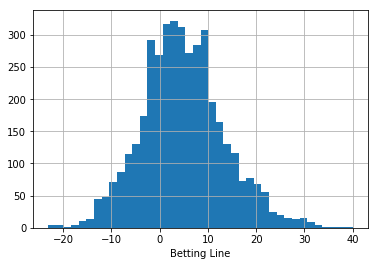

In [21]:
odds_2017.lineavg.hist(bins=40)
plt.xlabel('Betting Line')
print("Mean betting line for home team: ", odds_2017.lineavg.mean())


Point spread is normally distributed and on average the home team is favored by ~5 points.

#### Plotting Residuals

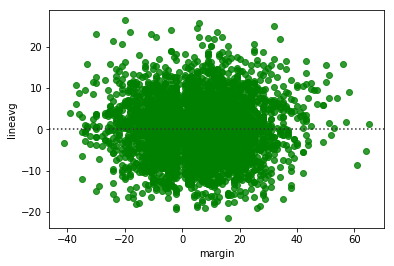

In [22]:
sns.residplot(data=odds_2017, x='margin', y='lineavg', color='green')

#### Plotting Betting Lines vs. Actual Results

Text(0.5,1,'Betting Line vs. Actual Results 2017-2018')

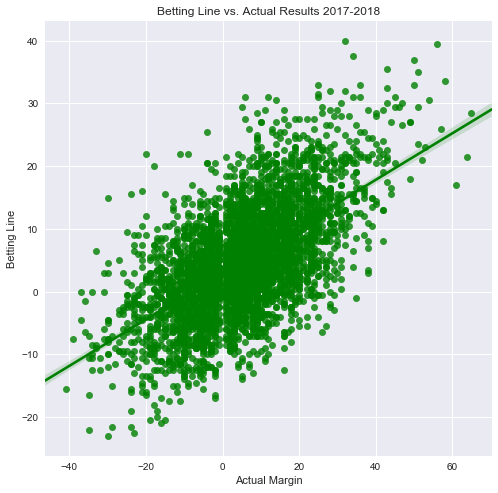

In [23]:
sns.set()
plt.figure(figsize=(8,8))
sns.regplot(data=odds_2017, x='margin', y='lineavg', fit_reg=True, color='green')
plt.xlabel('Actual Margin')
plt.ylabel('Betting Line')
plt.title('Betting Line vs. Actual Results 2017-2018')

#### Distribution of Elo Rankings

In [24]:
K=25
#elos = elo.season_elos(rs_c.reset_index(drop=True), K=K)
elos = pd.read_csv(data_dir+'SeasonElos.csv')
elos.to_csv(data_dir+"SeasonElosK{}.csv".format(K))
elos.rename({'team_id':'TeamID', 'season_elo':'SeasonElo', 'season':'Season'}, axis=1, inplace=True)
elos.SeasonElo = elos.SeasonElo.astype(float)

In [25]:
elos['Team'] = list(map((lambda x: teams.loc[teams.TeamID==x, 'TeamName'].values[0]), elos['TeamID']))


In [26]:
tourney_teams_by_season = dict(df_stats.groupby('Season')['TeamID'].unique())

In [27]:
tourney_teams_by_season[2018]

array([1437, 1345, 1403, 1455, 1452, 1196, 1116, 1439, 1104, 1139, 1382,
       1417, 1293, 1267, 1372, 1168, 1254, 1347, 1242, 1181, 1277, 1120,
       1155, 1395, 1348, 1371, 1301, 1328, 1113, 1393, 1308, 1158, 1137,
       1233, 1335, 1438, 1153, 1397, 1112, 1246, 1274, 1305, 1166, 1243,
       1400, 1260, 1172, 1138, 1460, 1209, 1420, 1462, 1314, 1276, 1211,
       1326, 1222, 1401, 1281, 1199, 1344, 1361, 1355, 1422, 1285, 1252,
       1300, 1411], dtype=int64)

In [28]:
season=2018
tourney_elos_2018 = elos.loc[(elos.Season==season) & (elos.TeamID.isin(tourney_teams_by_season[season]))].sort_values('SeasonElo', ascending=False)
tourney_elos_2018

,Season,SeasonElo,TeamID,Team
10053,2018,2131.147125,1437,Villanova
10087,2018,2127.413973,1438,Virginia
3301,2018,2067.646521,1211,Gonzaga
2373,2018,2057.680130,1181,Duke
4182,2018,2043.647495,1242,Kansas
6314,2018,2039.485518,1314,North Carolina
321,2018,2035.096586,1112,Arizona
7234,2018,2030.091226,1345,Purdue
4297,2018,2013.839687,1246,Kentucky
5279,2018,2006.320371,1277,Michigan St


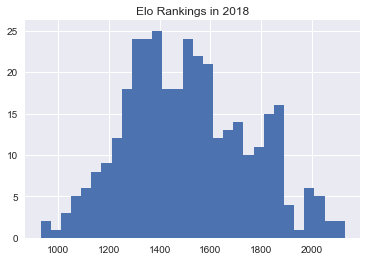

In [29]:
plt.title('Elo Rankings in 2018')
elos.loc[elos.Season==2018, 'SeasonElo'].hist(bins=30)

### Initializing NCAA Tournament DataFrames

In [30]:
tourney_cr = pd.read_csv(data_dir+'NCAATourneyCompactResults.csv')
start = 2003
tourney_cr.drop(['WLoc', 'NumOT'], axis=1, inplace=True)
tourney_cr = tourney_cr[tourney_cr.Season >= start]
tourney_cr['WMargin'] = tourney_cr.WScore - tourney_cr.LScore
tourney_cr.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin
2112,2017,146,1314,75,1246,73,2
2113,2017,146,1376,77,1196,70,7
2114,2017,152,1211,77,1376,73,4
2115,2017,152,1314,77,1332,76,1
2116,2017,154,1314,71,1211,65,6


In [31]:
elos = pd.read_csv(data_dir+'SeasonElos.csv')
elos.rename({'team_id':'TeamID', 'season_elo':'SeasonElo', 'season':'Season'}, axis=1, inplace=True)
elos.head()

,Season,SeasonElo,TeamID
0,2014,1394.749393,1101
1,2015,1278.262520,1101
2,2016,1196.713023,1101
3,2017,1220.408517,1101
4,2018,1271.214779,1101


In [32]:
def winloss_features(df_teams, df_feature, feature_cols, merge_on=['Season'], team_id='TeamID'):
    '''
    Takes input:
    df_teams: a dataframe with columns that specify the winning and losing team, identified by arg team_id
    df_features: a dataframe with features (e.g. stats) that each team has.
    feature_cols: the columns from df_features to extract
    merge_on: the common columns from df_teams and df_features to merge to. Default is 'Season'
    team_id: The name of the column that contains the team identifier for both df_teams and df_features. Default is 'TeamID'.
    Outputs: 
    df_concat: a dataframe containing the original info from df_teams with columns that contain the features for each team
    from df_features
    '''
    
    # Separate teams by win/loss
    w_team_id = 'W'+team_id
    l_team_id = 'L'+team_id
    
    # Prepare columns for feature dataframe
    w_cols = ['W{}'.format(feature) for feature in feature_cols]
    l_cols = ['L{}'.format(feature) for feature in feature_cols]
    diff_cols = ['{}Diff'.format(feature) for feature in feature_cols]
    
    # Create a dict with key = feature, value = Wfeature or Lfeature
    w_dict = dict(zip(feature_cols, w_cols))
    w_dict[team_id] = w_team_id
    
    l_dict = dict(zip(feature_cols, l_cols))
    l_dict[team_id] = l_team_id
    
    df_wins = df_feature.rename(columns=w_dict)
    df_losses = df_feature.rename(columns=l_dict)
    
    # Prepare common columns to merge on
    w_merge_on = merge_on + [w_team_id]
    l_merge_on = merge_on + [l_team_id]
    
    # Merge the dataframes that contain the winning team's features with the losing team's features
    df_dummy = pd.merge(left=df_teams, right=df_wins, how='left', on=w_merge_on)
    df_concat = pd.merge(left=df_dummy, right=df_losses, on=l_merge_on)
    df_concat = df_concat.reindex(columns=list(df_concat.columns)+diff_cols)
    df_concat[diff_cols] = df_concat[w_cols].values - df_concat[l_cols].values
    
    return df_concat



In [33]:
# Extract Elo Rating from winning and losing team
df_tourney_stats = winloss_features(df_teams=tourney_cr, df_feature=elos, feature_cols=['SeasonElo'], team_id='TeamID')
df_tourney_stats.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WMargin,WSeasonElo,LSeasonElo,SeasonEloDiff
976,2017,146,1314,75,1246,73,2,2069.157282,2070.780643,-1.623361
977,2017,146,1376,77,1196,70,7,1842.426256,1891.163905,-48.737649
978,2017,152,1211,77,1376,73,4,2029.173847,1842.426256,186.747591
979,2017,152,1314,77,1332,76,1,2069.157282,1948.444923,120.712359
980,2017,154,1314,71,1211,65,6,2069.157282,2029.173847,39.983435


(0, 50)

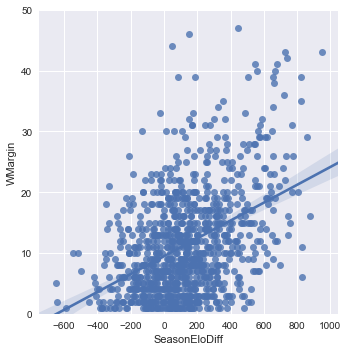

In [34]:
sns.lmplot(data=df_tourney_stats, x='SeasonEloDiff', y='WMargin')
plt.ylim(0,50)

### Extracting Statistics from Regular Season Results

In [35]:
rs_c = pd.read_csv(data_dir+'RegularSeasonCompactResults.csv')
rs_c = rs_c.loc[rs_c.Season>=start]
rs_c.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
74048,2003,10,1104,68,1328,62,N,0
74049,2003,10,1272,70,1393,63,N,0
74050,2003,11,1266,73,1437,61,N,0
74051,2003,11,1296,56,1457,50,N,0
74052,2003,11,1400,77,1208,71,N,0


In [36]:
rs_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82041 entries, 74048 to 156088
Data columns (total 8 columns):
Season     82041 non-null int64
DayNum     82041 non-null int64
WTeamID    82041 non-null int64
WScore     82041 non-null int64
LTeamID    82041 non-null int64
LScore     82041 non-null int64
WLoc       82041 non-null object
NumOT      82041 non-null int64
dtypes: int64(7), object(1)
memory usage: 5.6+ MB


In [37]:
import itertools

def get_schedule(teamID, df_season, teamID_cols=['WTeamID', 'LTeamID']):
    
    teams = (df_season.loc[(df_season.WTeamID==teamID)|(df_season.LTeamID==teamID), teamID_cols]).values
    # flatten list
    teams = list(itertools.chain(*teams))
    
    # remove the current team's ID from list of teams
    teams = list(filter(lambda team: team != teamID, teams))

    return teams

# Build dictionary of season schedules
schedules = dict()
for season in tourney_teams_by_season.keys():
    season_schedule = dict()
    for team in tourney_teams_by_season[season]:
        df_season = rs_c.loc[(rs_c.Season==season)]
        team_schedule = get_schedule(team, df_season)
        season_schedule[team] = team_schedule
    schedules[season] = season_schedule
    

In [38]:
# Calculate average opponent elo ratings
df_stats['AvgOppElo'] = None

for season in schedules.keys():
    for team in schedules[season].keys():
        opps = schedules[season][team]
        opp_elos = [elos.loc[(elos.Season==season) & (elos.TeamID==opp), 'SeasonElo'].values[0] for opp in opps]
        avg_opp_elo = np.mean(opp_elos)
        df_stats.loc[(df_stats.Season==season) & (df_stats.TeamID==team), 'AvgOppElo'] = avg_opp_elo
        
df_stats.tail(16)

,Season,Seed,TeamID,AvgOppElo
1048,2018,2,1314,1809.67
1049,2018,3,1276,1715.99
1050,2018,4,1211,1579.47
1051,2018,5,1326,1716.99
1052,2018,6,1222,1628.78
1053,2018,7,1401,1746.09
1054,2018,8,1281,1735.27
1055,2018,9,1199,1711.1
1056,2018,10,1344,1740.34
1057,2018,11,1361,1602.44


In [39]:
elo_history = pd.read_csv(data_dir+"EloHistory.csv", index_col=0).sort_index().reset_index(drop=True).rename(
    {'season':'Season',
     'season_elo':'SeasonElo',
    'team_id':'TeamID'}, axis=1)
elo_history.head()

,Season,SeasonElo,TeamID
0,2003,1492.267272,1328
1,2003,1507.732728,1104
2,2003,1508.412765,1272
3,2003,1491.587235,1393
4,2003,1511.636215,1266


In [40]:
def last_n_elos(elo_history, season, team, elo_col = 'SeasonElo', n=10):
    '''
    Takes input:
    df_elos: a chronologically sorted dataframe of regular season elo ratings
    team: team ID of elo ratings of interest
    season: season of elo ratings of interest
    n: the last n elo ratings from the final game
    '''
    row = [season, team]
    last_n_elos = elo_history.loc[(elo_history.Season == season) & (elo_history.TeamID == team), elo_col].tail(n).values
    row += list(last_n_elos)
    return row

In [41]:
elos.head()

,Season,SeasonElo,TeamID
0,2014,1394.749393,1101
1,2015,1278.262520,1101
2,2016,1196.713023,1101
3,2017,1220.408517,1101
4,2018,1271.214779,1101


In [42]:
df_stats.head()

,Season,Seed,TeamID,AvgOppElo
0,2003,1,1328,1666.09
1,2003,2,1448,1721.85
2,2003,3,1393,1679.63
3,2003,4,1257,1666.2
4,2003,5,1280,1712.34


In [43]:
df_stats.columns.values

array(['Season', 'Seed', 'TeamID', 'AvgOppElo'], dtype=object)

In [44]:
n=12
df_last_n_elos = df_stats.copy()
to_drop = ['Seed','AvgOppElo']
df_last_n_elos.drop(to_drop, axis=1, inplace=True)
last_n_basic_cols = df_last_n_elos.columns.values
elo_cols = ['FinalElo{}'.format(i) for i in range(n,0,-1)]
df_last_n_elos = pd.concat([df_last_n_elos,pd.DataFrame(columns=elo_cols)])
df_last_n_elos = df_last_n_elos[list(last_n_basic_cols)+list(elo_cols)]
print("Assigning last n elos...")
# Index values: 0 = Season, 1 = TeamID
#df_last_n_elos[elo_cols] = df_last_n_elos.apply(lambda x: last_n_elos(elo_history, x[0], x[1], n=n), axis=1)
df_last_n_elos = df_last_n_elos.apply(lambda x: last_n_elos(elo_history, x[0], x[1], n=n), axis=1)
df_last_n_elos.tail(16)

Assigning last n elos...


,Season,TeamID,FinalElo12,FinalElo11,FinalElo10,FinalElo9,FinalElo8,FinalElo7,FinalElo6,FinalElo5,FinalElo4,FinalElo3,FinalElo2,FinalElo1
1048,2018.0,1314.0,1959.950024,1964.673874,1969.054130,1974.002359,1992.864440,1997.162806,1985.887683,1979.525006,1986.090143,1994.822695,2002.473803,1995.657060
1049,2018.0,1276.0,1878.982948,1880.438968,1868.470644,1878.738904,1882.095045,1888.346524,1896.605189,1916.804834,1919.512705,1926.315789,1938.861545,1950.422401
1050,2018.0,1211.0,2005.365086,2005.782106,2007.264955,2008.376304,2020.658400,2021.121482,2021.268450,2022.112943,2027.431874,2027.954856,2030.032774,2034.242308
1051,2018.0,1326.0,1844.089814,1846.007899,1834.138838,1839.708883,1842.211184,1850.537089,1855.075246,1835.081665,1828.830187,1831.185026,1836.286046,1830.665779
1052,2018.0,1222.0,1763.827202,1773.776852,1776.834371,1786.406187,1803.505526,1793.976463,1796.380103,1813.963079,1817.109335,1827.922886,1836.361336,1834.042470
1053,2018.0,1401.0,1767.203814,1776.109222,1786.458690,1792.095509,1806.880984,1799.536275,1788.234630,1767.132963,1777.316726,1782.123059,1784.921582,1780.320892
1054,2018.0,1281.0,1606.543675,1626.451058,1647.583373,1659.628348,1664.346192,1671.690900,1668.678545,1660.362433,1658.104150,1671.904084,1683.325629,1679.320823
1055,2018.0,1199.0,1871.067834,1877.311536,1867.319648,1878.656637,1873.982180,1862.626943,1865.507665,1867.214180,1848.572124,1839.447703,1841.220751,1834.384961
1056,2018.0,1344.0,1792.414569,1794.738417,1754.364366,1768.092356,1761.849330,1748.375013,1756.267506,1753.243560,1755.498661,1764.194450,1773.573968,1771.243199
1057,2018.0,1361.0,1713.809076,1702.333486,1694.002211,1697.968663,1710.143021,1714.329645,1716.807336,1724.047822,1731.178692,1741.200487,1760.488421,1765.768967


In [45]:
# import json
# import pickle

# f = open("schedules.pkl", "wb")
# pickle.dump(schedules, f)
# f.close()
# #json_file = json.dumps(schedules)
# sched = pickle.Unpickler.load("schedules.pkl")

In [46]:
tourney_d = pd.read_csv(data_dir+"NCAATourneyDetailedResults.csv")
tourney_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 34 columns):
Season     981 non-null int64
DayNum     981 non-null int64
WTeamID    981 non-null int64
WScore     981 non-null int64
LTeamID    981 non-null int64
LScore     981 non-null int64
WLoc       981 non-null object
NumOT      981 non-null int64
WFGM       981 non-null int64
WFGA       981 non-null int64
WFGM3      981 non-null int64
WFGA3      981 non-null int64
WFTM       981 non-null int64
WFTA       981 non-null int64
WOR        981 non-null int64
WDR        981 non-null int64
WAst       981 non-null int64
WTO        981 non-null int64
WStl       981 non-null int64
WBlk       981 non-null int64
WPF        981 non-null int64
LFGM       981 non-null int64
LFGA       981 non-null int64
LFGM3      981 non-null int64
LFGA3      981 non-null int64
LFTM       981 non-null int64
LFTA       981 non-null int64
LOR        981 non-null int64
LDR        981 non-null int64
LAst       981 non-null 

In [47]:
def get_sum(df, stat, w_mask, l_mask):
    summed = df[w_mask]['W'+stat].sum() + df[l_mask]['L'+stat].sum()
    return summed

def get_sum_opp(df, stat, w_mask, l_mask):
    summed = df[l_mask]['W'+stat].sum() + df[w_mask]['L'+stat].sum()
    return summed

def percent(a, b):
    return a/(a + b)

def rate(a, b):
    return a / b